# Krypton Lifetime maps

### Author:  JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sun Jan 27 20:15:10 2019


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-01-27 20:15:10,125 | INFO : Hello world!


### Input files

In [3]:
from krcal.core.kr_types import KrFileName

run_number = 6820
num_files = 2366

if num_files > 7729:
    num_xy_bins = 100
else:
    num_xy_bins = 50

# run_number = 6340 # for testing only
t_start = time.time()

lifetime_limits = (2350, 5150)
e0_limits = (7000, 14000)
e0_limits_rphi = (12000, 14000)

input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
output_plots = f"$IC_DATA/plots"
output_plots = os.path.expandvars(f"{output_plots}/")
summary_outputs = "/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r"+str(run_number)+"/"
map_path    = f"$IC_DATA/maps"

# Find the name of the correct input dst

dst_directory = os.path.expandvars(f"{input_path}/")
dirlist = os.listdir(dst_directory)
dst_file = ""
for file_name in dirlist:
    try:
        check_number = file_name
        check_number = check_number[check_number.find('_')+1:]
        check_number = check_number[:check_number.find('_')]
        if check_number == str(run_number):
            print('Found the dst:',file_name)
            dst_file = file_name
    except:
        pass

if dst_file == "":
    raise ValueError("Unable to find appropriate dst for run "+str(run_number))

input_file_names  = [ dst_file ]

    
time_bins = 25
output_file_name  = ' '
map_file_name     = 'kr_maps_xy_'+str(run_number)+'.h5'
map_file_name_ts  = f'kr_maps_rphi_5_8_ts_{time_bins}_'+str(run_number)+'.h5'
emap_file_name    = 'kr_emap_xy_'+str(num_xy_bins)+'_'+str(num_xy_bins)+'_r_'+str(run_number)+'.h5'

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

Found the dst: dst_6820_trigger1_0000_2365.h5


### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import timeit
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [10]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [11]:
from krcal.core.stat_functions      import mean_and_std

In [12]:
from krcal.core.analysis_functions  import kr_ranges_and_bins
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [13]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [14]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [15]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [16]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName

In [17]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [18]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average

In [19]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [20]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [21]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [22]:
from numpy import pi, sqrt

In [23]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [24]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [25]:
log = logging.getLogger()

### Input/output 

In [26]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [27]:
t0 = time.time()
dst           = load_dsts(fn.input_file_names, "DST", "Events")
t1 = time.time()
print(f'Read in file time: t = {t1 -t0}')

Read in file time: t = 0.5979170799255371


In [28]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 172270


In [29]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [30]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [31]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = num_xy_bins,
                                                        ynbins    = num_xy_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [32]:
dst = dst[in_range(dst.R, 0, RMAX)]

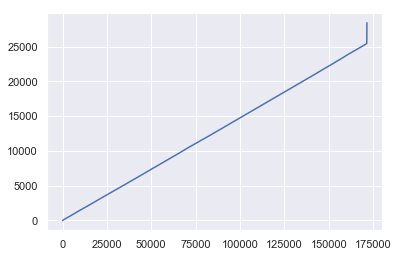

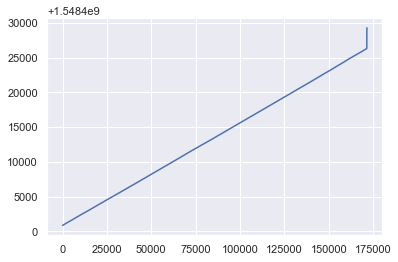

In [33]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
plt.plot(DT)
plt.show()
plt.plot(T)
plt.show()

In [34]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

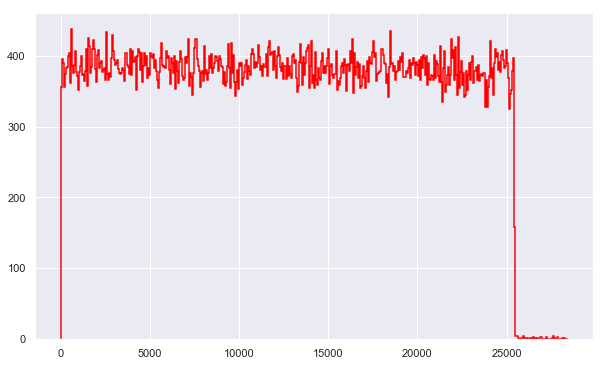

In [35]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Time 

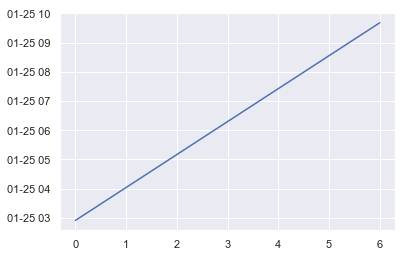

In [36]:
plt.plot(krTimes.timeStamps)

### Event distribution

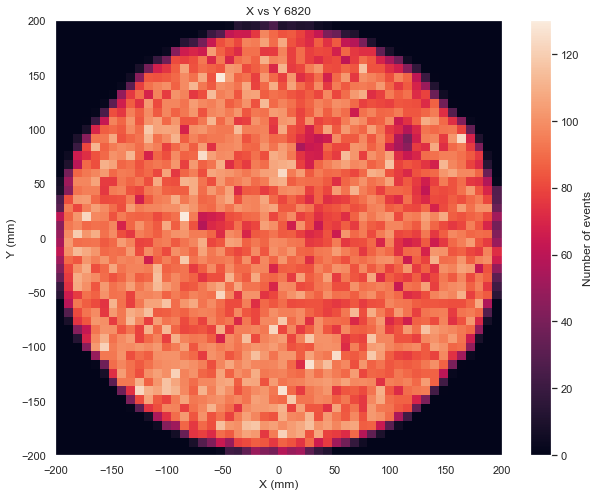

In [37]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y '+str(run_number)),
           profile=False,
           figsize=(10,8))
plt.savefig(output_plots+'/EventDists/EventDist_'+str(run_number)+'.png')

## Time series

In [38]:
log.setLevel(logging.INFO)

### Divide dst in 100 time series

In [39]:
time_bins = 25
t0 = time.time()

ts, masks = get_time_series(time_bins, (DT[0],DT[-1]), kge)
t1 = time.time()
print(f' get_time_series: t = {t1 -t0}')

 get_time_series: t = 0.011363983154296875


### Fit lifetime full detector

In [40]:
t0 = time.time()
fps = time_fcs(ts, masks, kge, 
               nbins_z = 15,
               nbins_e = 25,
               range_z = (10, 550),
               range_e = (7000, 14000),
               energy  = 'S2e',
               fit     = FitType.profile) # lifetime fit parameter time series
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 0.17740702629089355


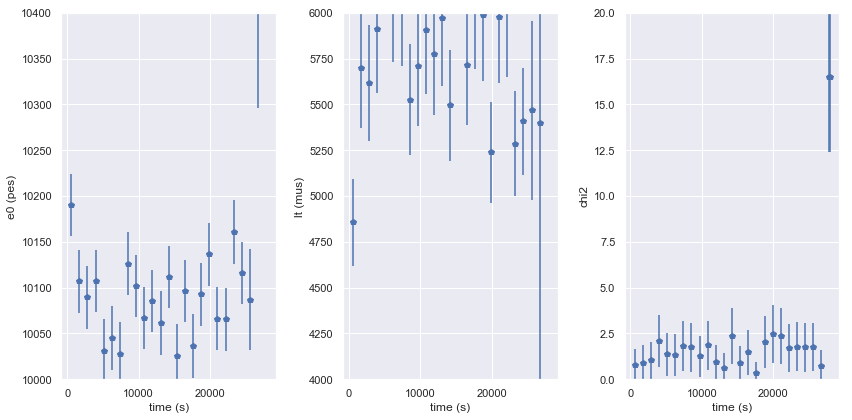

In [41]:
plot_time_fcs(fps,
              range_chi2  = (0,20),
              range_e0    = (10000,10400),
              range_lt    = (4000, 6000),
              figsize     = (12,6))

## Lifetime in RPhi

In [42]:
NSECTORS =5  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.
#NSECTORS =4  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
#SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.

In [43]:
rpsmd = rphi_sector_map_def(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)

In [44]:
W = define_rphi_sectors(rpsmd)

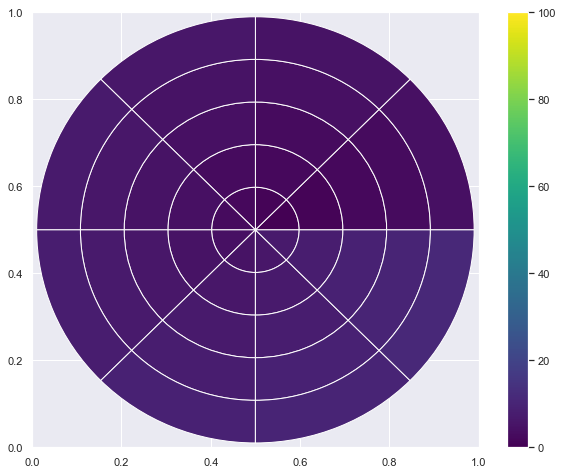

In [45]:
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [46]:
t0 = time.time()
KSRP = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 0.43789005279541016


In [47]:
neM = event_map(KSRP)

In [48]:
neM

,0,1,2,3,4
0,887,2751,4599,6481,7696
1,896,2647,4602,6699,7649
2,891,2672,4457,6526,7535
3,839,2682,4328,5995,7512
4,794,2464,4481,5492,7094
5,841,2703,4276,6114,6291
6,936,2762,4596,6496,6419
7,850,2541,4690,6249,7105


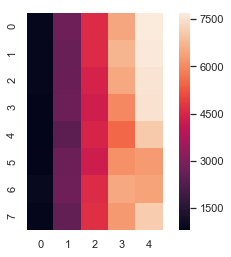

In [49]:
ax = sns.heatmap(neM, square=True)

### four phi sectors: upper half (left-right), lower half (left-right) of chamber

### R < 40 mm

In [50]:
erange = (0,14500)
ltrange = (0, 7000)

2019-01-27 20:15:22,016 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,018 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,020 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, r

2019-01-27 20:15:22,251 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,252 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,253 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)


2019-01-27 20:15:22,485 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,487 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,488 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)


2019-01-27 20:15:22,708 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,709 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,710 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,902 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,903 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:22,904 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation,

2019-01-27 20:15:23,123 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:23,124 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:23,125 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)


2019-01-27 20:15:23,367 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:23,369 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:23,370 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)


2019-01-27 20:15:23,607 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:23,608 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:23,609 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)


2019-01-27 20:15:24,091 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,092 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,092 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,246 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,247 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,249 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:24,417 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,418 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,422 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,562 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,563 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,564 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

2019-01-27 20:15:24,718 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,720 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,721 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,869 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,872 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:24,875 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:25,019 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,020 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,021 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,154 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,157 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,158 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:15:25,675 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,677 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,678 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,820 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,821 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,822 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:25,998 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:25,999 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,000 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,139 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,141 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,144 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:26,305 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,306 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,308 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,468 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,469 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,470 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:15:26,641 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,642 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,644 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,817 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,818 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:26,819 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:15:27,357 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,358 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,359 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,494 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,495 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, re

2019-01-27 20:15:27,650 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,651 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,652 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,793 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,794 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,795 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:27,936 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,937 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:27,938 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,063 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,065 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,067 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

2019-01-27 20:15:28,196 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,198 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,200 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,325 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,326 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,326 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warni

2019-01-27 20:15:28,807 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,808 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,809 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,972 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,973 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:28,974 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:29,111 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,113 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,114 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,252 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,254 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,256 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:29,389 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,390 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,390 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,523 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,526 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,527 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:29,692 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,693 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,694 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,843 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,844 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:29,844 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

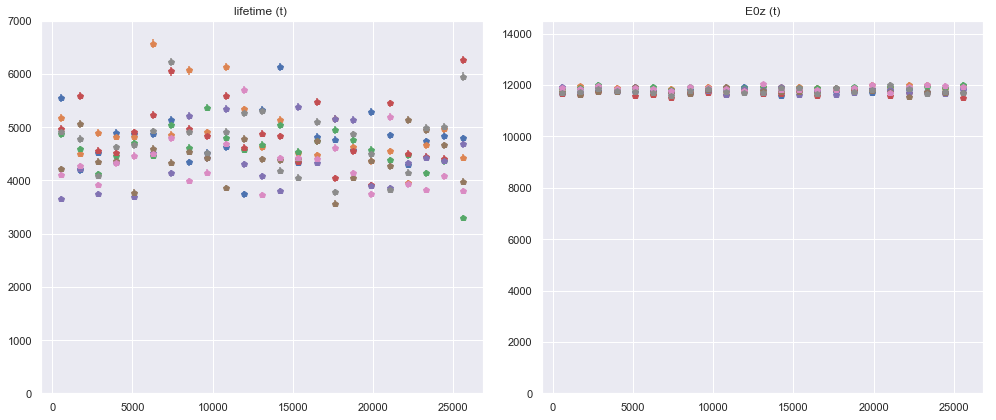

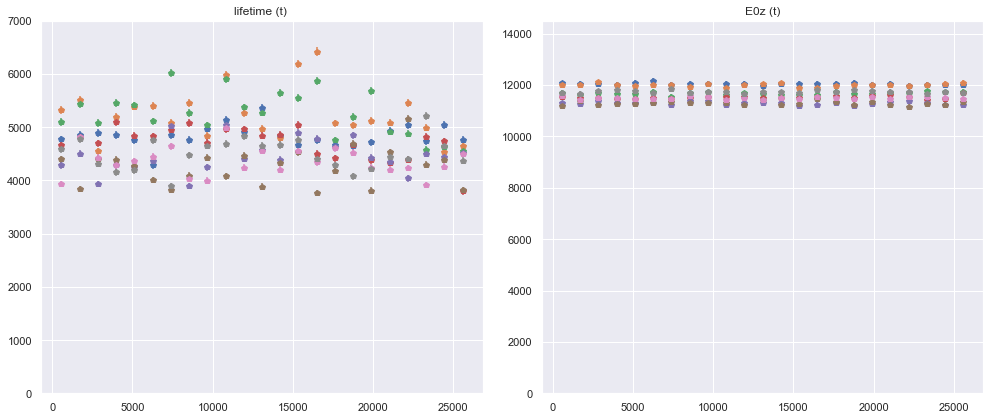

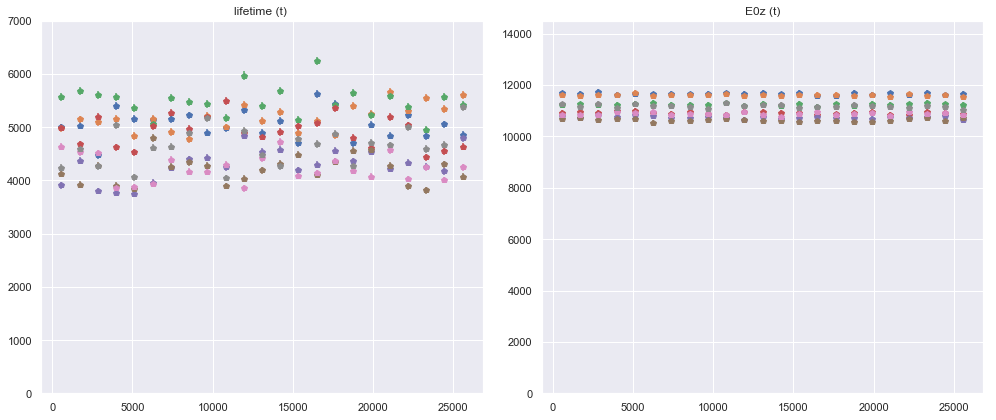

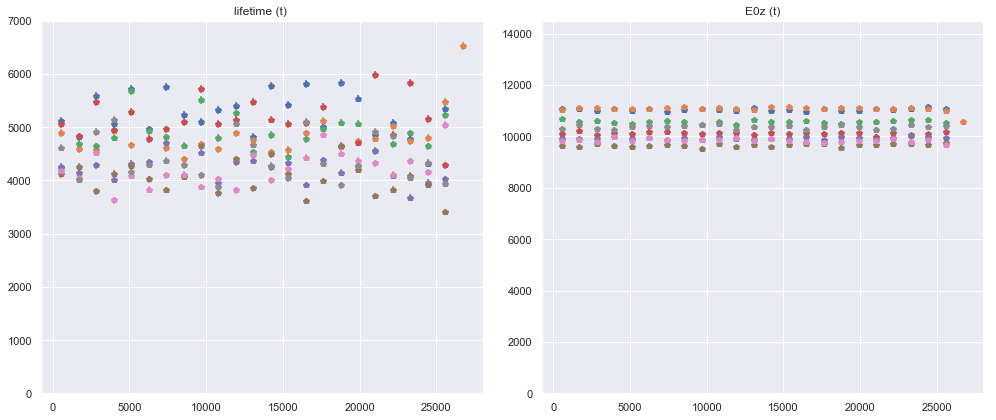

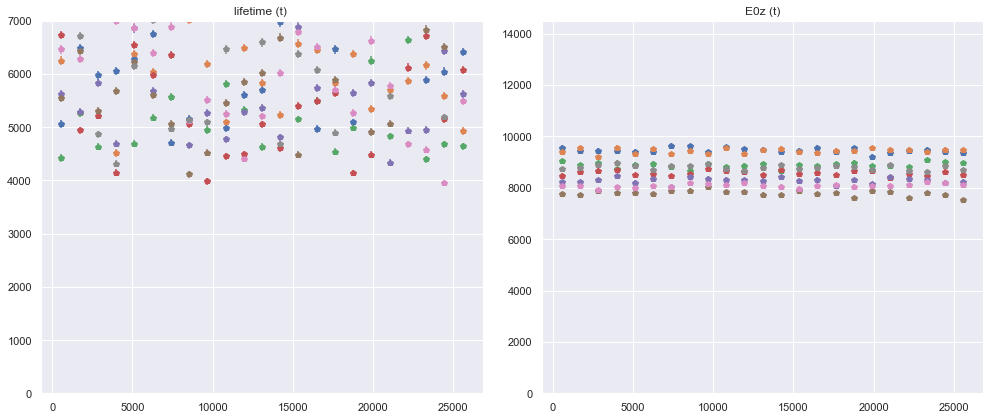

In [51]:
for sector in range(NSECTORS):
    fps = fit_fcs_in_rphi_sectors(sector = sector,
                              selection_map = KSRP,
                              event_map     = neM,
                              n_time_bins   = time_bins,
                              time_diffs    = DT,
                              nbins_z       = 25,
                              nbins_e       = 50,
                              range_z       =(50, 550),
                              range_e       = (5000, 14500),
                              energy        = 'S2e',
                              fit           = FitType.unbined,
                              n_min         = 100)
    plot_fit_sectors(fps,  range_e0 =erange, range_lt=ltrange)
    plt.savefig(summary_outputs+'R_phi_lt'+str(sector+1)+'.png')

### Lifetime patterns:

- Oscillatory pattern in time with a swing of 1 ms!
- Lifetime changes also as a function of Phi, with differences that increase as R increases.
- R > 160 cm data shows very high and very variable lifetime, with a spread of several ms.

### Strategy

- Try to correct geometrical effects first. Fine grained geometrical map with a single time bin.
- Study time dependence later

## Divide chamber in sectors of XY

In [52]:
log.setLevel(logging.DEBUG)

In [53]:
t0 = time.time()
print(len(dst))
print(len(DT))
KRES = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

171538
171538
2019-01-27 20:15:31,859 | DEBUG :  function: select_xy_sectors


2019-01-27 20:15:31,860 | DEBUG :  calling selection_mask


2019-01-27 20:15:31,861 | DEBUG : computing selection mask for sector 0


2019-01-27 20:15:31,884 | DEBUG : computing selection mask for sector 1


2019-01-27 20:15:31,906 | DEBUG : computing selection mask for sector 2


2019-01-27 20:15:31,929 | DEBUG : computing selection mask for sector 3


2019-01-27 20:15:31,950 | DEBUG : computing selection mask for sector 4


2019-01-27 20:15:31,972 | DEBUG : computing selection mask for sector 5


2019-01-27 20:15:31,994 | DEBUG : computing selection mask for sector 6


2019-01-27 20:15:32,016 | DEBUG : computing selection mask for sector 7


2019-01-27 20:15:32,038 | DEBUG : computing selection mask for sector 8


2019-01-27 20:15:32,059 | DEBUG : computing selection mask for sector 9


2019-01-27 20:15:32,081 | DEBUG : computing selection mask for sector 10


2019-01-27 20:15:32,102 | DEBUG : computing selection mask for sector 11


2019-01-27 20:15:32,124 | DEBUG : computing selection mask for sector 12


2019-01-27 20:15:32,145 | DEBUG : computing selection mask for sector 13


2019-01-27 20:15:32,168 | DEBUG : computing selection mask for sector 14


2019-01-27 20:15:32,190 | DEBUG : computing selection mask for sector 15


2019-01-27 20:15:32,212 | DEBUG : computing selection mask for sector 16


2019-01-27 20:15:32,234 | DEBUG : computing selection mask for sector 17


2019-01-27 20:15:32,255 | DEBUG : computing selection mask for sector 18


2019-01-27 20:15:32,277 | DEBUG : computing selection mask for sector 19


2019-01-27 20:15:32,298 | DEBUG : computing selection mask for sector 20


2019-01-27 20:15:32,320 | DEBUG : computing selection mask for sector 21


2019-01-27 20:15:32,342 | DEBUG : computing selection mask for sector 22


2019-01-27 20:15:32,364 | DEBUG : computing selection mask for sector 23


2019-01-27 20:15:32,385 | DEBUG : computing selection mask for sector 24


2019-01-27 20:15:32,407 | DEBUG : computing selection mask for sector 25


2019-01-27 20:15:32,430 | DEBUG : computing selection mask for sector 26


2019-01-27 20:15:32,451 | DEBUG : computing selection mask for sector 27


2019-01-27 20:15:32,479 | DEBUG : computing selection mask for sector 28


2019-01-27 20:15:32,513 | DEBUG : computing selection mask for sector 29


2019-01-27 20:15:32,538 | DEBUG : computing selection mask for sector 30


2019-01-27 20:15:32,561 | DEBUG : computing selection mask for sector 31


2019-01-27 20:15:32,585 | DEBUG : computing selection mask for sector 32


2019-01-27 20:15:32,606 | DEBUG : computing selection mask for sector 33


2019-01-27 20:15:32,628 | DEBUG : computing selection mask for sector 34


2019-01-27 20:15:32,650 | DEBUG : computing selection mask for sector 35


2019-01-27 20:15:32,671 | DEBUG : computing selection mask for sector 36


2019-01-27 20:15:32,694 | DEBUG : computing selection mask for sector 37


2019-01-27 20:15:32,718 | DEBUG : computing selection mask for sector 38


2019-01-27 20:15:32,741 | DEBUG : computing selection mask for sector 39


2019-01-27 20:15:32,765 | DEBUG : computing selection mask for sector 40


2019-01-27 20:15:32,788 | DEBUG : computing selection mask for sector 41


2019-01-27 20:15:32,817 | DEBUG : computing selection mask for sector 42


2019-01-27 20:15:32,844 | DEBUG : computing selection mask for sector 43


2019-01-27 20:15:32,871 | DEBUG : computing selection mask for sector 44


2019-01-27 20:15:32,898 | DEBUG : computing selection mask for sector 45


2019-01-27 20:15:32,925 | DEBUG : computing selection mask for sector 46


2019-01-27 20:15:32,953 | DEBUG : computing selection mask for sector 47


2019-01-27 20:15:32,980 | DEBUG : computing selection mask for sector 48


2019-01-27 20:15:33,005 | DEBUG : computing selection mask for sector 49


2019-01-27 20:15:33,031 | DEBUG :  selection mask computed, filling selections


2019-01-27 20:15:33,032 | DEBUG :  defining kr_event for sector 0


2019-01-27 20:15:33,054 | DEBUG :  defining kr_event for sector 1


2019-01-27 20:15:33,078 | DEBUG :  defining kr_event for sector 2


2019-01-27 20:15:33,102 | DEBUG :  defining kr_event for sector 3


2019-01-27 20:15:33,132 | DEBUG :  defining kr_event for sector 4


2019-01-27 20:15:33,162 | DEBUG :  defining kr_event for sector 5


2019-01-27 20:15:33,191 | DEBUG :  defining kr_event for sector 6


2019-01-27 20:15:33,222 | DEBUG :  defining kr_event for sector 7


2019-01-27 20:15:33,254 | DEBUG :  defining kr_event for sector 8


2019-01-27 20:15:33,287 | DEBUG :  defining kr_event for sector 9


2019-01-27 20:15:33,321 | DEBUG :  defining kr_event for sector 10


2019-01-27 20:15:33,354 | DEBUG :  defining kr_event for sector 11


2019-01-27 20:15:33,389 | DEBUG :  defining kr_event for sector 12


2019-01-27 20:15:33,424 | DEBUG :  defining kr_event for sector 13


2019-01-27 20:15:33,459 | DEBUG :  defining kr_event for sector 14


2019-01-27 20:15:33,542 | DEBUG :  defining kr_event for sector 15


2019-01-27 20:15:33,588 | DEBUG :  defining kr_event for sector 16


2019-01-27 20:15:33,626 | DEBUG :  defining kr_event for sector 17

2019-01-27 20:15:33,667 | DEBUG :  defining kr_event for sector 18


2019-01-27 20:15:33,703 | DEBUG :  defining kr_event for sector 19


2019-01-27 20:15:33,739 | DEBUG :  defining kr_event for sector 20


2019-01-27 20:15:33,775 | DEBUG :  defining kr_event for sector 21


2019-01-27 20:15:33,811 | DEBUG :  defining kr_event for sector 22


2019-01-27 20:15:33,848 | DEBUG :  defining kr_event for sector 23


2019-01-27 20:15:33,886 | DEBUG :  defining kr_event for sector 24


2019-01-27 20:15:33,921 | DEBUG :  defining kr_event for sector 25


2019-01-27 20:15:33,958 | DEBUG :  defining kr_event for sector 26


2019-01-27 20:15:33,996 | DEBUG :  defining kr_event for sector 27


2019-01-27 20:15:34,032 | DEBUG :  defining kr_event for sector 28


2019-01-27 20:15:34,068 | DEBUG :  defining kr_event for sector 29


2019-01-27 20:15:34,104 | DEBUG :  defining kr_event for sector 30


2019-01-27 20:15:34,142 | DEBUG :  defining kr_event for sector 31


2019-01-27 20:15:34,177 | DEBUG :  defining kr_event for sector 32


2019-01-27 20:15:34,213 | DEBUG :  defining kr_event for sector 33


2019-01-27 20:15:34,252 | DEBUG :  defining kr_event for sector 34


2019-01-27 20:15:34,292 | DEBUG :  defining kr_event for sector 35


2019-01-27 20:15:34,326 | DEBUG :  defining kr_event for sector 36


2019-01-27 20:15:34,362 | DEBUG :  defining kr_event for sector 37


2019-01-27 20:15:34,395 | DEBUG :  defining kr_event for sector 38


2019-01-27 20:15:34,428 | DEBUG :  defining kr_event for sector 39


2019-01-27 20:15:34,463 | DEBUG :  defining kr_event for sector 40


2019-01-27 20:15:34,494 | DEBUG :  defining kr_event for sector 41

2019-01-27 20:15:34,526 | DEBUG :  defining kr_event for sector 42


2019-01-27 20:15:34,556 | DEBUG :  defining kr_event for sector 43


2019-01-27 20:15:34,585 | DEBUG :  defining kr_event for sector 44


2019-01-27 20:15:34,613 | DEBUG :  defining kr_event for sector 45


2019-01-27 20:15:34,641 | DEBUG :  defining kr_event for sector 46


2019-01-27 20:15:34,667 | DEBUG :  defining kr_event for sector 47


2019-01-27 20:15:34,692 | DEBUG :  defining kr_event for sector 48


2019-01-27 20:15:34,716 | DEBUG :  defining kr_event for sector 49


2019-01-27 20:15:34,736 | DEBUG :  RGES computed


 KRES: t = 2.9214940071105957


In [54]:
log.setLevel(logging.INFO)

In [55]:
neM = event_map(KRES)

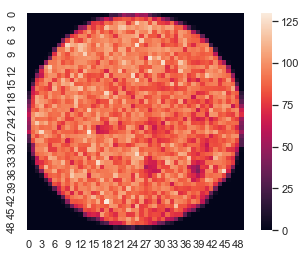

In [56]:
ax = sns.heatmap(neM, square=True)

## Fits in XY sectors

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```


### Single time bin

In [57]:
t0 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fpmxy = fit_map_xy(selection_map = KRES,
                       event_map     = neM,
                       n_time_bins   = 1,
                       time_diffs    = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy        = 'S2e',
                       fit           = FitType.unbined,
                       n_min         = 100)

t1 = time.time()
print(f' fpmxy: t = {t1 -t0}')

 fpmxy: t = 2.5248148441314697


In [58]:
times = fpmxy[0][0].ts

In [59]:
times

array([14217.])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [60]:
tsm = tsmap_from_fmap(fpmxy)

<ErrorbarContainer object of 3 artists>

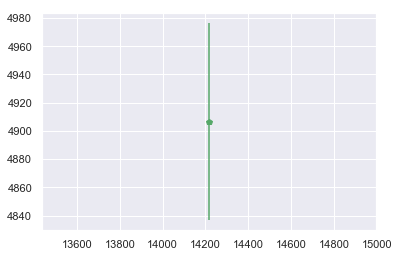

In [61]:
plt.errorbar(times, tsm.lt[25][25], np.sqrt(tsm.lt[25][25]), fmt="p")
plt.errorbar(times, tsm.lt[25][21], np.sqrt(tsm.lt[25][21]), fmt="p")
plt.errorbar(times, tsm.lt[25][22], np.sqrt(tsm.lt[25][22]), fmt="p")

<ErrorbarContainer object of 3 artists>

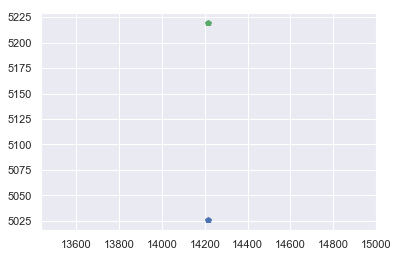

In [62]:
plt.errorbar(times, tsm.lt[30][10], np.sqrt(tsm.lt[6][10]), fmt="p")
plt.errorbar(times, tsm.lt[30][11], np.sqrt(tsm.lt[6][11]), fmt="p")
plt.errorbar(times, tsm.lt[30][12], np.sqrt(tsm.lt[6][12]), fmt="p")

### Obtain amap from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : DataFrame
    e0    : DataFrame
    lt    : DataFrame
    e0u   : DataFrame
    ltu   : DataFrame
```
 

#### There is a single time series (ts = 0)

In [63]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [64]:
amap_average(am) 

ASectorMap(chi2=1.126013700049111, e0=10217.692619769517, lt=4544.246647248475, e0u=49.902996592441475, ltu=295.8892444805673, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [65]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2019-01-27 20:15:38,991 | INFO :  set nans to average value of interval = 9500.0


2019-01-27 20:15:39,105 | INFO :  set nans to average value of interval = 3500.0


In [66]:
amap_average(rmap)

ASectorMap(chi2=1.126013700049111, e0=10217.692619769517, lt=4527.293503119918, e0u=49.902996592441475, ltu=293.90354588978755, mapinfo=None)

In [67]:
asm = relative_errors(rmap)

In [68]:
amv = amap_average(asm)

#### Draw the maps using default colormap

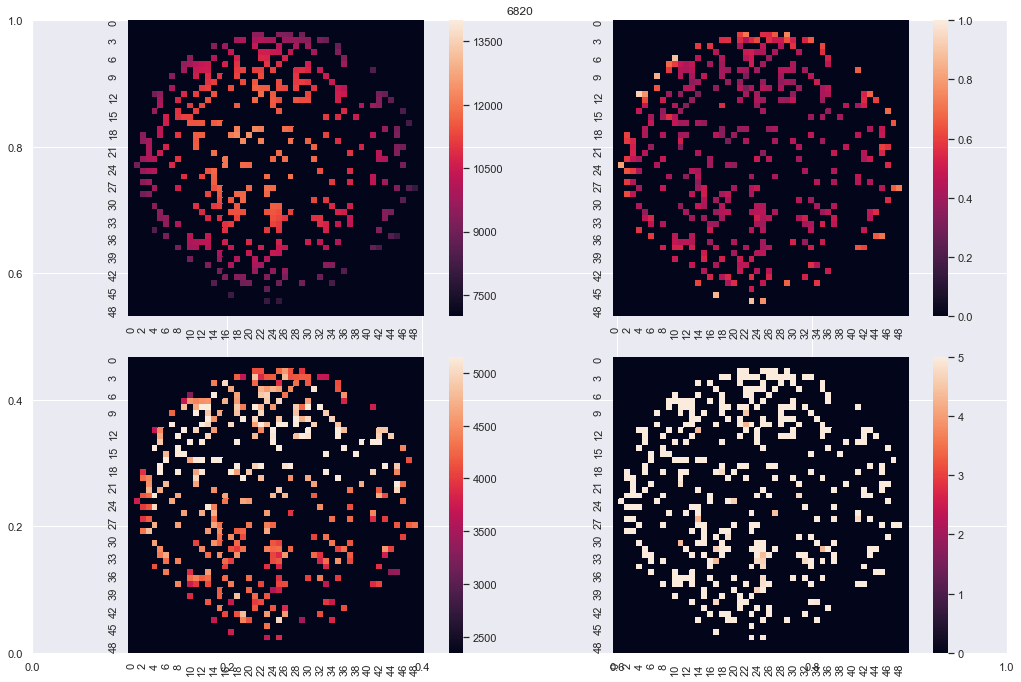

In [69]:
draw_xy_maps(asm,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10),
            showPlots = False,
            plot_title = str(run_number))
plt.savefig(output_plots+'/lt_e0_xy_maps/lt_e0_xy_'+str(run_number)+'.png')
plt.savefig(summary_outputs+'maps.png')

In [70]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [71]:
amap_avg_list=amap_average(asmAv)

text_output = open(output_plots+'/text_outputs/outputs_'+str(run_number)+'.txt','w')

text_output.write('chi2='+str(amap_avg_list.chi2)+'\n')
text_output.write('e0='+str(amap_avg_list.e0)+'\n')
text_output.write('lt='+str(amap_avg_list.lt)+'\n')
text_output.write('e0u='+str(amap_avg_list.e0u)+'\n')
text_output.write('ltu='+str(amap_avg_list.ltu)+'\n')

mean = 0
num = 0

mean_low = 0
mean_high = 0

num_low = 0
num_high = 0

variance = 0
var_low = 0
var_high = 0

stdev = 0
stdev_low = 0
stdev_high = 0

zero_filled = asm.lt.fillna(0)
print(len(zero_filled))
for x in range(len(zero_filled)):
    ymax = len(zero_filled[x])
    for y in range(ymax):
        if (zero_filled[x][y] != 0):
            # get the mean
            mean += zero_filled[x][y]
            num += 1
            # get the means for low and high
            if y < ymax / 2:
                num_high += 1
                mean_high += zero_filled[x][y]
            else:
                num_low += 1
                mean_low += zero_filled[x][y]

mean /= num
mean_low /= num_low
mean_high /= num_high

for x in range(len(zero_filled)):
    ymax = len(zero_filled[x])
    for y in range(ymax):
        if (zero_filled[x][y] != 0):
            variance += (zero_filled[x][y] - mean)**2 / num
            if y < ymax / 2:
                var_high += (zero_filled[x][y] - mean_high)**2 / num_high
            else:
                var_low += (zero_filled[x][y] - mean_low)**2 / num_low
            
stdev = variance**0.5
stdev_low = var_low**0.5
stdev_high = var_high**0.5

mean_diff = (mean_high - mean_low) / mean


text_output.write('lt_mean_diff='+str(mean_diff)+'\n')
text_output.write('lt_mean_low='+str(mean_low)+'\n')
text_output.write('lt_mean_high='+str(mean_high)+'\n')
text_output.write('lt_stdev='+str(stdev)+'\n')
text_output.write('lt_stdev_low='+str(stdev_low)+'\n')
text_output.write('lt_stdev_high='+str(stdev_high)+'\n')

text_output.close()

amap_avg_list
print(asm.lt)

50


    0            1            2            3            4            5   \
0  NaN          NaN          NaN          NaN          NaN          NaN   
1  NaN          NaN          NaN          NaN          NaN          NaN   
2  NaN          NaN          NaN          NaN          NaN          NaN   
3  NaN          NaN          NaN          NaN          NaN          NaN   
4  NaN          NaN          NaN          NaN          NaN          NaN   
5  NaN          NaN          NaN          NaN          NaN          NaN   
6  NaN          NaN          NaN          NaN          NaN          NaN   
7  NaN          NaN          NaN          NaN          NaN          NaN   
8  NaN          NaN          NaN          NaN          NaN          NaN   
9  NaN          NaN          NaN          NaN          NaN          NaN   
10 NaN          NaN          NaN          NaN          NaN          NaN   
11 NaN          NaN          NaN          NaN          NaN          NaN   
12 NaN          NaN      

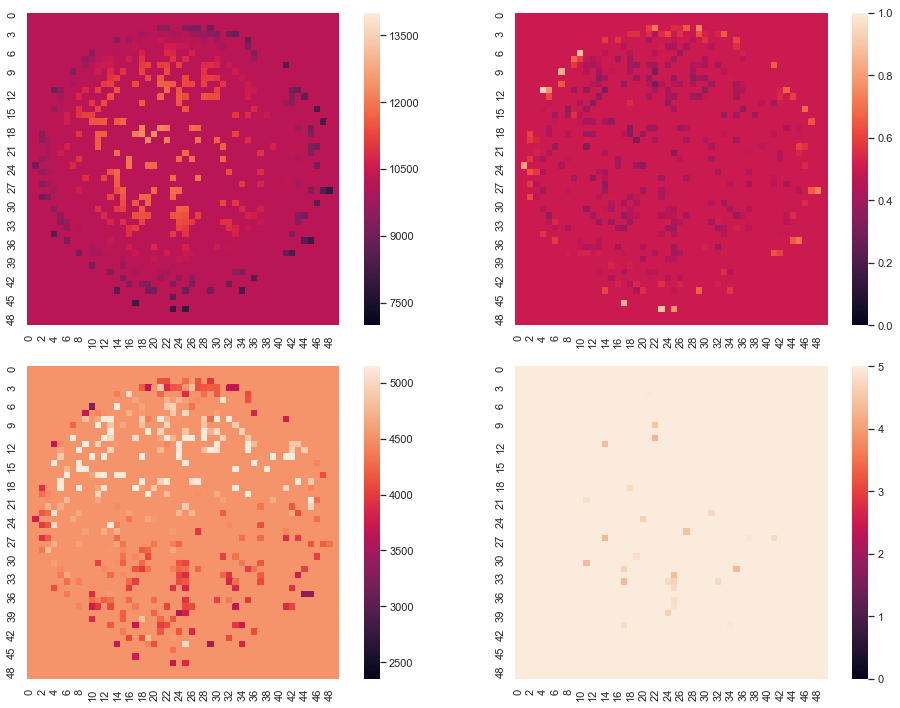

In [72]:
draw_xy_maps(asmAv,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

### Save to file

In [73]:
print('The map info is:')
print(asmAv.mapinfo)
write_maps(asmAv, filename=fn.emap_file_name)

The map info is:
None


### Read back

In [74]:
emaps = read_maps(filename=fn.emap_file_name)

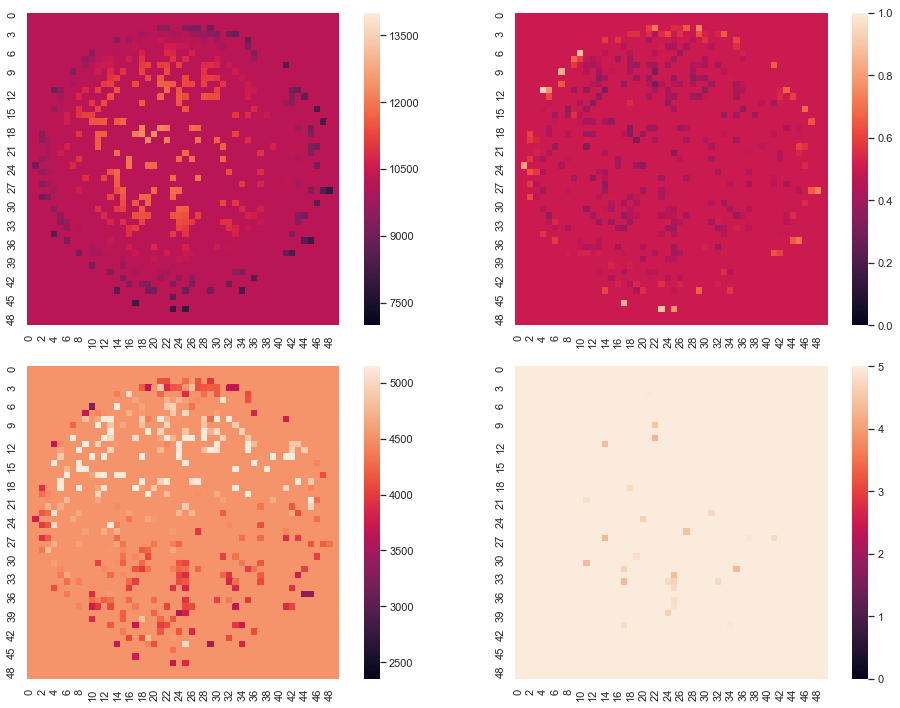

In [75]:
draw_xy_maps(emaps,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [76]:
amap_average(emaps)

ASectorMap(chi2=1.1277323886917408, e0=10251.72084777317, lt=4529.322037005076, e0u=0.49366664884810296, ltu=6.436171323467163, mapinfo=None)

In [77]:
norm = amap_max(emaps)

In [78]:
norm

ASectorMap(chi2=6.956253831622245, e0=12386.30448552673, lt=5973.666558728366, e0u=0.9307365924202381, ltu=11.291947147893229, mapinfo=None)

In [79]:
t0 = time.time()
E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = krNbins.X, 
                      ny  = krNbins.Y)


t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 2.944483995437622


In [80]:
t0 = time.time()
KRP = select_rphi_sectors(dst, DT, E0, dst.S2q, W)
t1 = time.time()
print(f' KRP: t = {t1 -t0}')

 KRP: t = 0.4694063663482666


In [81]:
neM = event_map(KRP)

In [82]:
neM

,0,1,2,3,4
0,887,2751,4599,6481,7696
1,896,2647,4602,6699,7649
2,891,2672,4457,6526,7535
3,839,2682,4328,5995,7512
4,794,2464,4481,5492,7094
5,841,2703,4276,6114,6291
6,936,2762,4596,6496,6419
7,850,2541,4690,6249,7105


In [83]:
neM[0]

0    887
1    896
2    891
3    839
4    794
5    841
6    936
7    850
Name: 0, dtype: int64

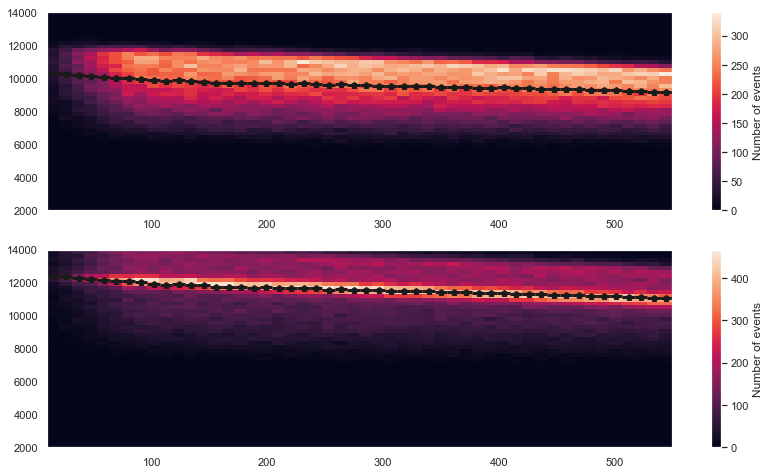

In [84]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

### Now compute maps in rphi.

In [85]:
t0 = time.time()
fmap = fit_map_rphi(selection_map    = KRP,
                       event_map     = neM,
                       n_time_bins   = time_bins,
                       time_diffs     = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy         = 'S2e',
                       fit            = FitType.unbined,
                       n_min          = 100)
t1 = time.time()
print(f' fmap: t = {t1 -t0}')

2019-01-27 20:15:55,387 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,388 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,389 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,565 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,566 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,567 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, r

2019-01-27 20:15:55,731 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,732 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,733 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,885 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,886 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:55,886 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, re

2019-01-27 20:15:56,030 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,031 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,032 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,174 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,175 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,175 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, r

2019-01-27 20:15:56,355 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,356 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,358 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,513 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,515 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,516 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}

2019-01-27 20:15:56,680 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,681 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,682 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,817 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,818 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,819 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:56,985 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,986 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:56,987 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,146 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,147 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,148 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

2019-01-27 20:15:57,285 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,286 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,287 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,413 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,414 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,415 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:57,577 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,578 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,580 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,715 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,716 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,718 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:15:57,875 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,876 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:57,877 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,022 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,023 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,024 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:58,187 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,188 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,189 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,334 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,336 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,337 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:58,511 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,514 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,518 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,660 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,661 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,662 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:15:58,806 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,807 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,808 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,932 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,933 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:58,935 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:15:59,058 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,059 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,060 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,189 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,190 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, re

2019-01-27 20:15:59,344 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,345 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,346 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,489 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,490 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,493 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:15:59,655 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,656 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,658 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,786 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,788 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,789 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

2019-01-27 20:15:59,955 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,956 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:15:59,958 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,097 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,098 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,100 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warni

2019-01-27 20:16:00,268 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,270 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,271 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,398 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,400 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,403 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:00,529 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,530 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,532 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,693 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,695 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,696 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:00,835 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,838 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,839 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,993 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,994 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:00,995 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:01,141 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:01,143 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:01,145 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:01,287 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:01,289 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:01,290 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


 fmap: t = 6.057105302810669


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

In [86]:
tsm = tsmap_from_fmap(fmap)

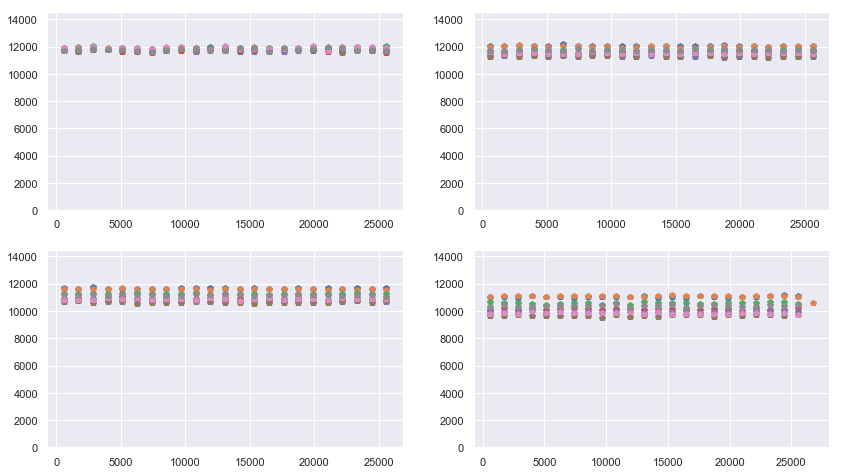

In [87]:
erange=(0, 14500)
fig = plt.figure(figsize=(14,8))
for j in range(0,4):
    ax      = fig.add_subplot(2, 2, j+1)
    plt.ylim(erange)
    for i in neM.index:
        plt.errorbar(ts, tsm.e0[j][i], np.sqrt(tsm.e0[0][i]), fmt="p")

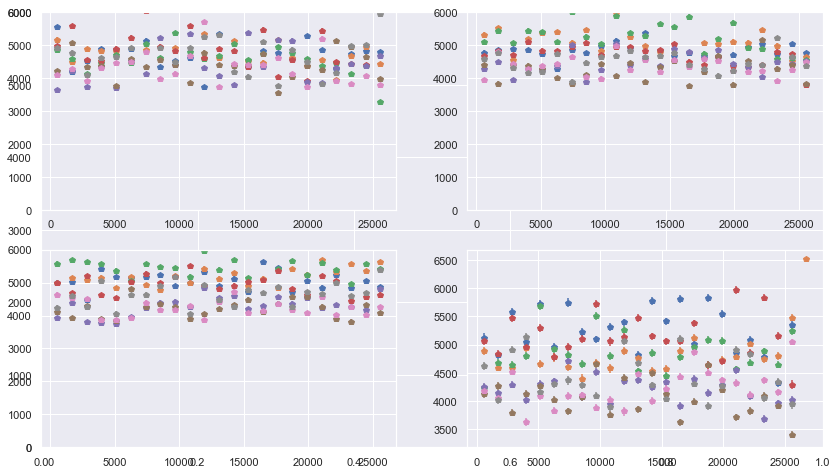

In [88]:
fig = plt.figure(figsize=(14,8))
ltrange=(0, 6000)
for j in range(0,4):
    plt.ylim(ltrange)
    ax      = fig.add_subplot(2, 2, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsm.lt[j][i], np.sqrt(tsm.lt[0][i]), fmt="p")
#

In [89]:
t0 = time.time()
fmap2 = fit_map_rphi(selection_map    = KRP,
                       event_map     = neM,
                       n_time_bins   = time_bins,
                       time_diffs     = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy         = 'E',
                       fit            = FitType.unbined,
                       n_min          = 100)
t1 = time.time()
print(f' fmap: t = {t1 -t0}')

2019-01-27 20:16:03,817 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:03,818 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:03,819 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:03,988 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:03,989 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:03,989 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, r

2019-01-27 20:16:04,150 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,151 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,152 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,299 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,300 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,301 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, re

2019-01-27 20:16:04,506 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,507 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,508 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,681 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,682 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,683 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, r

2019-01-27 20:16:04,841 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,842 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,843 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,990 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,991 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:04,992 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}

2019-01-27 20:16:05,145 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,146 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,147 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,287 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,289 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,290 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:05,421 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,423 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,424 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,561 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,562 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,563 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

2019-01-27 20:16:05,702 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,703 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,704 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,845 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,847 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,850 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:05,987 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,988 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:05,989 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,138 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,140 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,141 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:16:06,281 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,283 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,284 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,418 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,420 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,422 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:06,570 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,571 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,572 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,722 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,723 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,725 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:06,865 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,866 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:06,870 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,012 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,013 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,013 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:16:07,154 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,155 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,156 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,294 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,295 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,297 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warning

2019-01-27 20:16:07,429 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,430 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,431 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,583 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,584 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, re

2019-01-27 20:16:07,734 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,735 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,736 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,878 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,878 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:07,879 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:08,013 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,014 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,015 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,141 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,142 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,143 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

2019-01-27 20:16:08,266 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,268 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,269 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,387 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,388 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,388 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warni

2019-01-27 20:16:08,514 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,515 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,516 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,634 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,635 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,636 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:08,780 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,782 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,784 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,934 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,938 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:08,939 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:09,112 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,113 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,114 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,271 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,273 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,277 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = 

2019-01-27 20:16:09,412 | WARNING : Value Error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,414 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,415 | WARNING : LinAlgError error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,540 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,541 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


2019-01-27 20:16:09,543 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit


 fmap: t = 5.978238105773926


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:257: RankWarning: Polyfit may be poorly conditioned
  cc, cov = np.polyfit(z, el, deg=1, full = False, w = None, cov = True )
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnings.warn(f' fit did not succeed, returning NaN ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_lt_functions.py:455: UserWarning:  fit did not succeed, returning NaN 
  warnin

In [90]:
tsm2 = tsmap_from_fmap(fmap2)

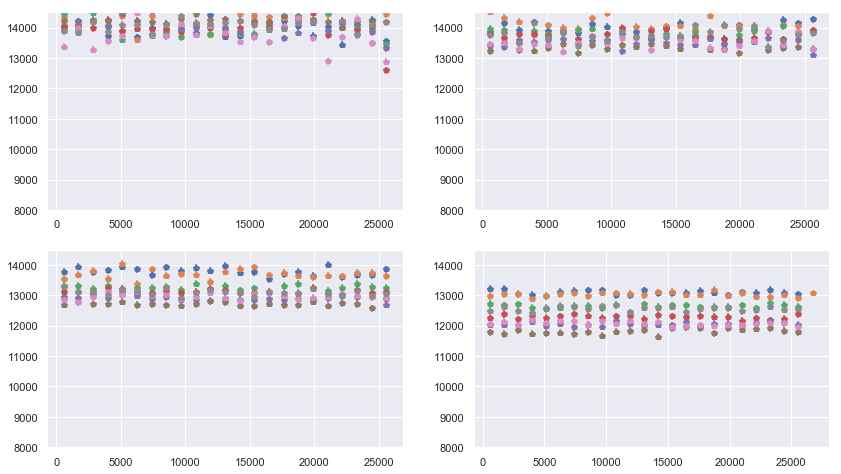

In [91]:
erange=(8000, 14500)
fig = plt.figure(figsize=(14,8))
for j in range(0,4):
    ax      = fig.add_subplot(2, 2, j+1)
    plt.ylim(erange)
    for i in neM.index:
        plt.errorbar(ts, tsm2.e0[j][i], np.sqrt(tsm2.e0[0][i]), fmt="p")

/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


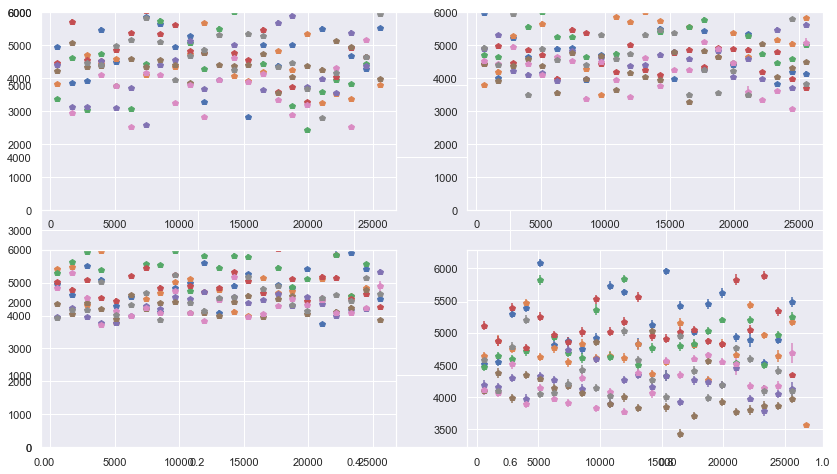

In [92]:
fig = plt.figure(figsize=(14,8))
ltrange=(0, 6000)
for j in range(0,4):
    plt.ylim(ltrange)
    ax      = fig.add_subplot(2, 2, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsm2.lt[j][i], np.sqrt(tsm2.lt[0][i]), fmt="p")

In [93]:
amts0 = amap_from_tsmap(tsm2, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [94]:
avam = amap_average(amts0) 
avam

ASectorMap(chi2=1.4524443890379062, e0=12815.26547883478, lt=4938.566728171061, e0u=141.48154342303266, ltu=858.3086179409263, mapinfo=None)

In [95]:
asm0 = relative_errors(amts0)

In [96]:
amap_average(asm0) 

ASectorMap(chi2=1.4524443890379062, e0=12815.26547883478, lt=4938.566728171061, e0u=1.098778150124691, ltu=16.209209004043014, mapinfo=None)

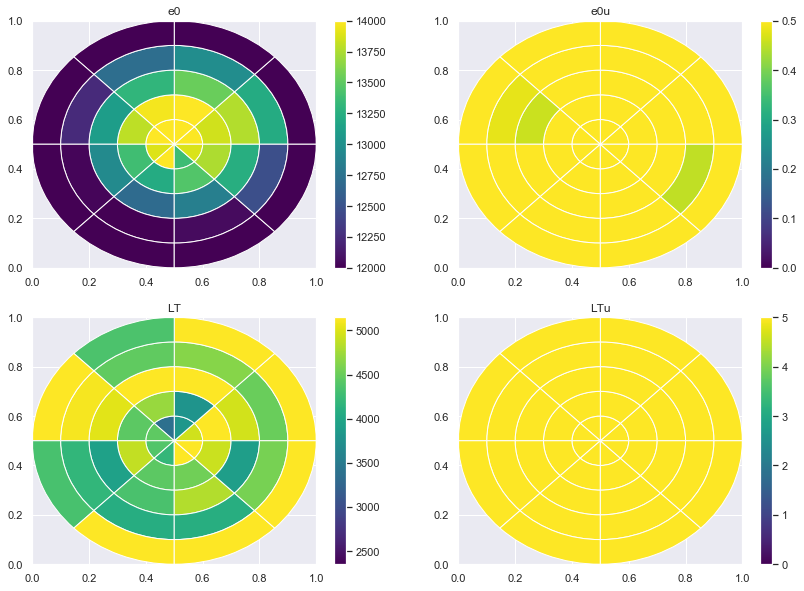

In [97]:
draw_rphi_maps(W, asm0,  
          e0lims  = e0_limits_rphi,
          ltlims  = lifetime_limits,
          eulims  = (0, 0.5),
          lulims  = (0,5),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


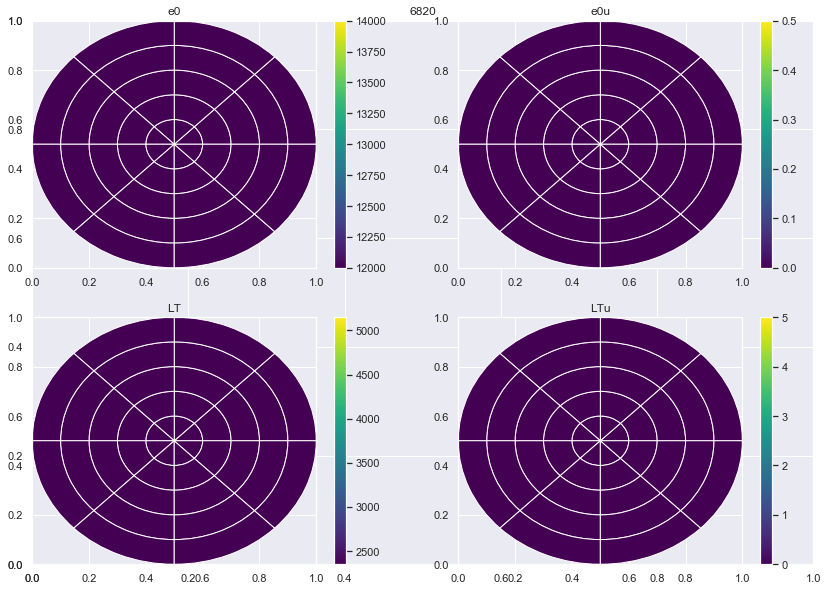

In [98]:
amts50 = amap_from_tsmap(tsm2, 
                     ts = 25, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)
asm50 = relative_errors(amts50)
amap_average(asm50) 

draw_rphi_maps(W, asm50,  
          e0lims  = e0_limits_rphi,
          ltlims  = lifetime_limits,
          eulims  = (0, 0.5),
          lulims  = (0,5),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10),
          showPlots = False,
          plot_title = str(run_number))
plt.savefig(output_plots+'/lt_e0_rphi_maps/lt_e0_rphi_'+str(run_number)+'.png')

### Maps for the full time series

In [99]:
aMaps = []
EE    = []
LT    = []
TT    = []
t0 = time.time()
for i, tt in enumerate(ts):
    am = amap_from_tsmap(tsm2, 
                         ts = i, 
                         range_e     = (5000, 14500),
                         range_chi2  = (0,100),
                         range_lt    = (3000,5000))
    amv = amap_average(am) 
    asm = relative_errors(am)
    av = amap_replace_nan_by_mean(asm, amMean=amv)
    av0 = amap_average(av) 
    aMaps.append(av)
    EE.append(av0.e0)
    LT.append(av0.lt)
    TT.append(tt)
t1 = time.time()
print(f' t = {t1 -t0}')

 t = 0.2676560878753662


(0, 14500)

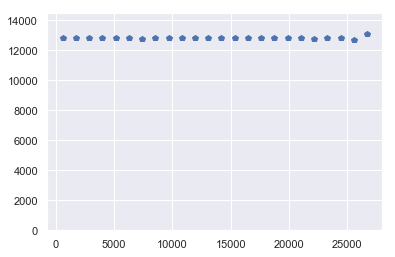

In [100]:
plt.errorbar(TT, EE, 10, fmt="p")
plt.ylim(0,14500)

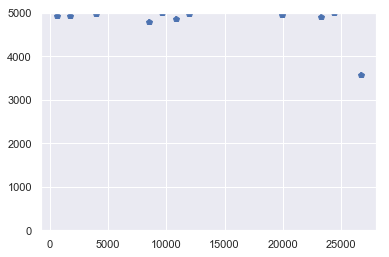

In [101]:
plt.errorbar(TT, LT, sqrt(LT), fmt="p")
plt.ylim(0,5000)
plt.savefig(summary_outputs+'AverageLT.png')

### Write maps

In [102]:
fn.map_file_name_ts

'/Volumes/NEXT_data/IC_Data//maps/kr_maps_rphi_5_8_ts_25_6820.h5'

In [103]:
write_maps_ts(aMaps, ts, filename=fn.map_file_name_ts)
time_write = time.time()

### Read maps

In [104]:
tts, tsMaps = read_maps_ts(fn.map_file_name_ts)

In [105]:
kdst = kr_event(dst, DT, E0, dst.S2q)
fr = RMAX / NSECTORS 

In [106]:
t0 = time.time()
kge =  e0_rphi_correction_ts(kdst, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' E0 correction: t = {t1 -t0}')

 E0 correction: t = 2.781352996826172


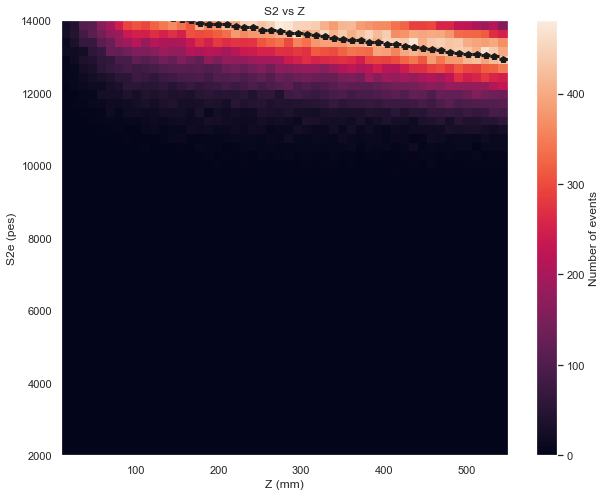

In [107]:
nevt = h2d(kge.Z, kge.E, 50, 50, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [108]:
t0 = time.time()
klt1 =  lt_rphi_correction_ts(kdst, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 2.813365936279297


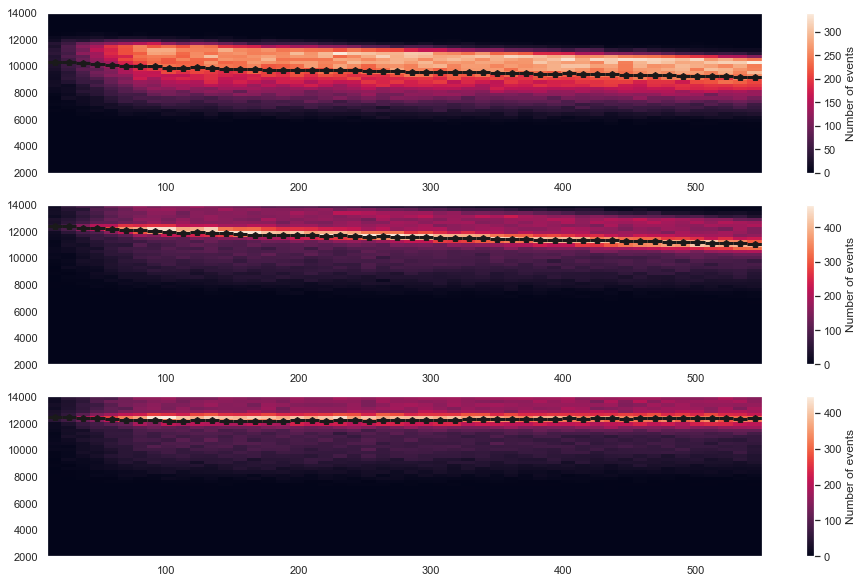

In [109]:
fig = plt.figure(figsize=(16,10))

ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

ax      = fig.add_subplot(3, 1, 3)
nevt = h2(klt1.Z, klt1.E, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

plt.savefig(summary_outputs+'CorrectionLT.png')

In [110]:
t0 = time.time()
klt =  lt_rphi_correction_ts(kge, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 2.790820837020874


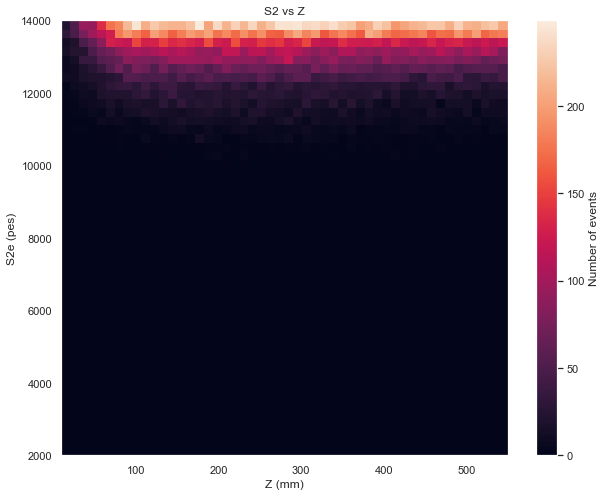

In [111]:
nevt = h2d(klt.Z, klt.E, 50, 50, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


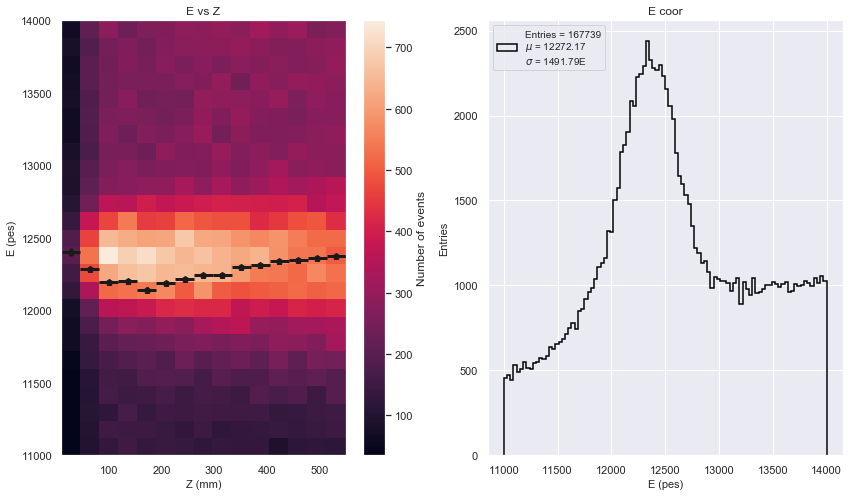

In [112]:
e_range = (11000, 14000)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(klt1.Z, klt1.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(klt1.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

In [113]:
fc = fit_energy(klt1.E, nbins=100, range=(12000, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

 fit failed for seed  = GaussPar(mu=Measurement(value=12272.168839754566, uncertainty=4.580615874572486), std=Measurement(value=1491.7906288938282, uncertainty=3.238999816038894), amp=Measurement(value=1121.4405338816907, uncertainty=8.1189685204077))  due to RunTimeError
  Fit was valid = False
 Emu       = 12272.168839754566 +-4.580615874572486 
 E sigma   = 1491.7906288938282 +-3.238999816038894 
 chi2    = -999999 
 sigma E/E (FWHM)     (%) =28.566327791580544
 sigma E/E (FWHM) Qbb (%) =3.689397119848767 


/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)


/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


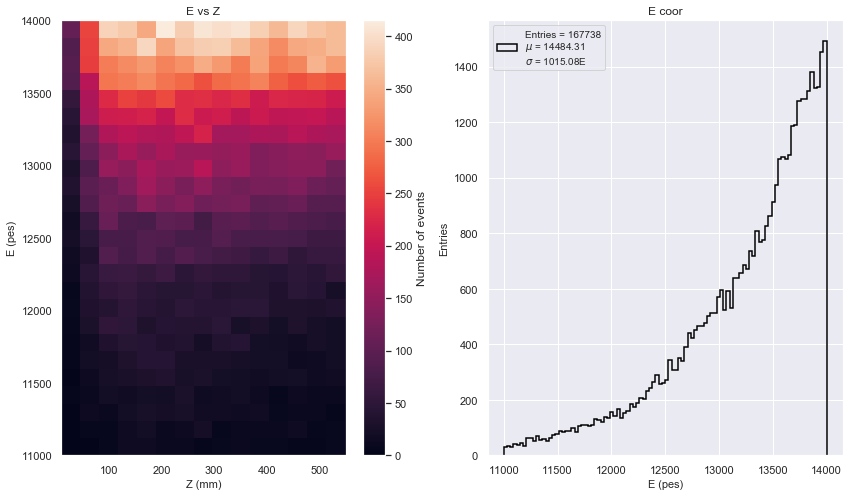

In [114]:
e_range = (11000, 14000)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(klt.Z, klt.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(klt.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


  Fit was valid = True
 Emu       = 18036.93362831469 +-362.3380142866316 
 E sigma   = 2065.6394367102803 +-81.97372148578512 
 chi2    = 1.0763916729759258 
 sigma E/E (FWHM)     (%) =26.9128488040166
 sigma E/E (FWHM) Qbb (%) =3.475847073831062 


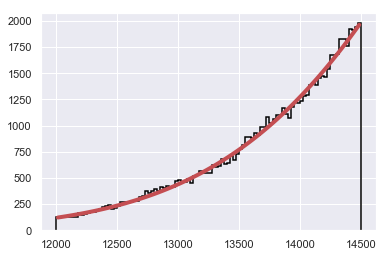

In [115]:
fc = fit_energy(klt.E, nbins=100, range=(12000, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)


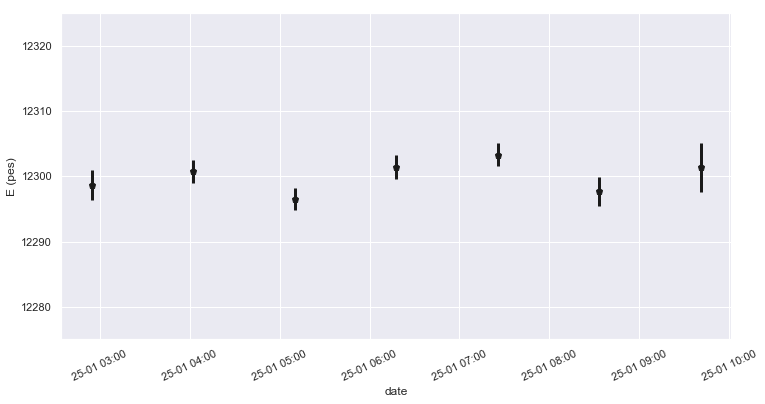

In [116]:
baseline = 12300
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(klt.T, klt.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(12275, 12325),
                    figsize=(12,6))

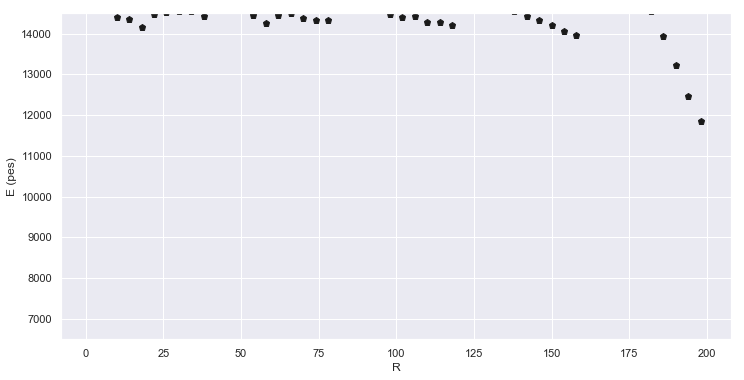

In [117]:
energy_X_profile(klt.R, klt.E, xnbins = num_xy_bins, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14500),  
                 figsize=(12,6))
plt.savefig(summary_outputs+'RProfile.png')

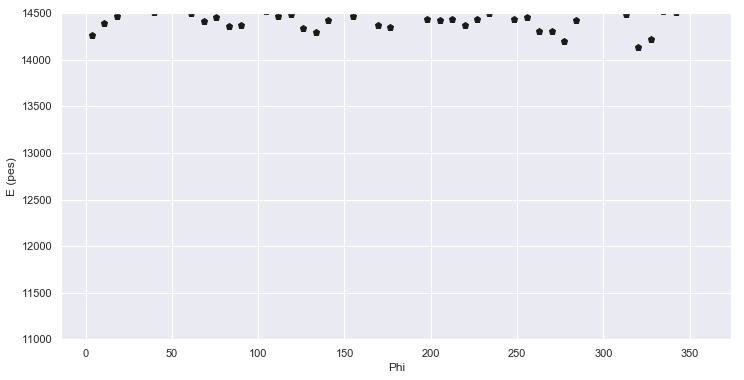

In [118]:
energy_X_profile(phirad_to_deg(klt.Phi), klt.E, xnbins = num_xy_bins, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 14500),  
                 figsize=(12,6))

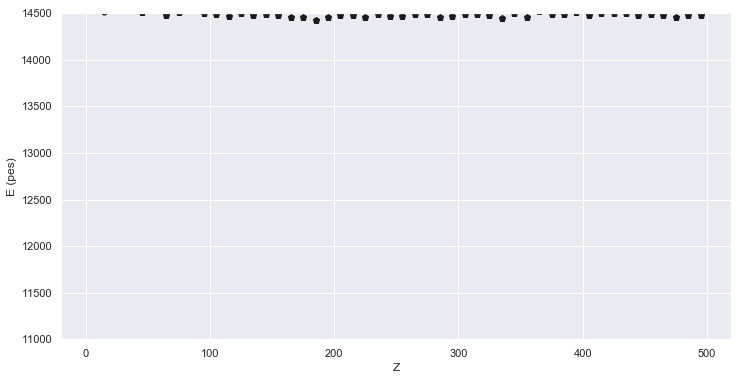

In [119]:
energy_X_profile(klt.Z, klt.E, xnbins = num_xy_bins, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 14500),   
                 figsize=(12,6))

(11000, 14500)

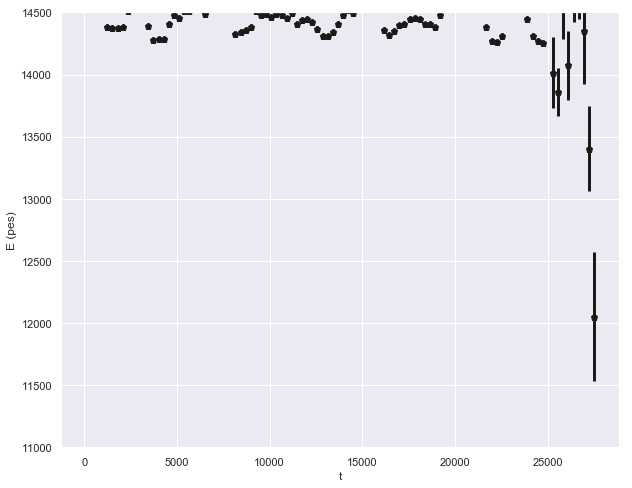

In [120]:
T   =(klt.T - klt.T.min()) 
t, e, eu = fitf.profileX(T, klt.E, 100)
erange =(11000, 14500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [121]:
e_mu    = np.nanmean(klt.E)
print(e_mu)
e_std   = np.nanstd (klt.E)
print(e_std)

14484.307616207589
1015.0805828779812


In [122]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = klt.E * ET_correction(T).value

(11000, 14500)

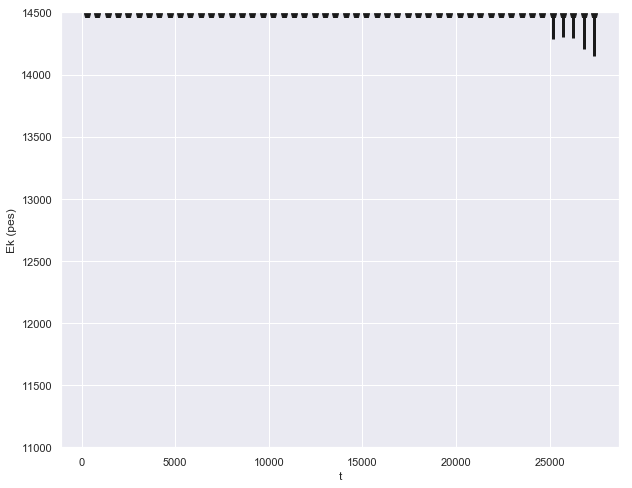

In [123]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

## Select events in region
- r < 180
- 10 < z < 550
- 5000 < E < 14500

In [124]:
rrange = (0, 180)

ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)

sel = in_range(dst.R, *rrange) & in_range(dst.Z, *z_range) &  in_range(E, *e_range)
kse = kr_event(dst, DT, E, dst.S2q, sel)  # kse = krypton selected event

Time spent in lt_xy_correction: 2.9244117736816406 s


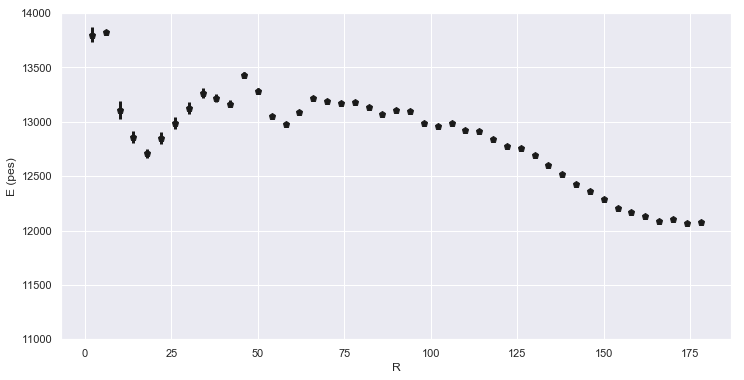

In [125]:
energy_X_profile(kse.R, kse.E, xnbins = num_xy_bins, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))
plt.savefig(summary_outputs+'RProfileC.png')

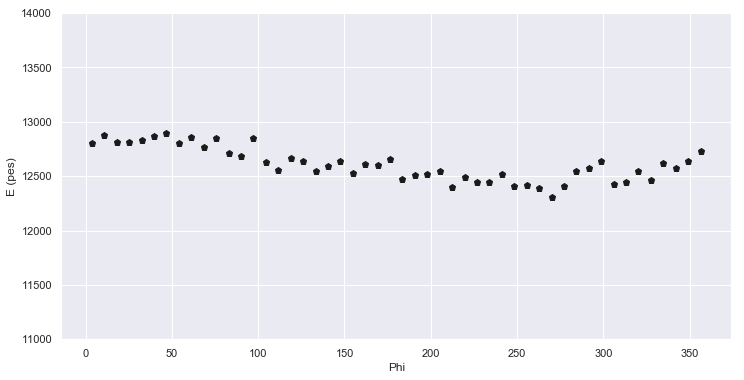

In [126]:
energy_X_profile(phirad_to_deg(kse.Phi), kse.E, xnbins = num_xy_bins, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))
plt.savefig(summary_outputs+'PhiProfile.png')

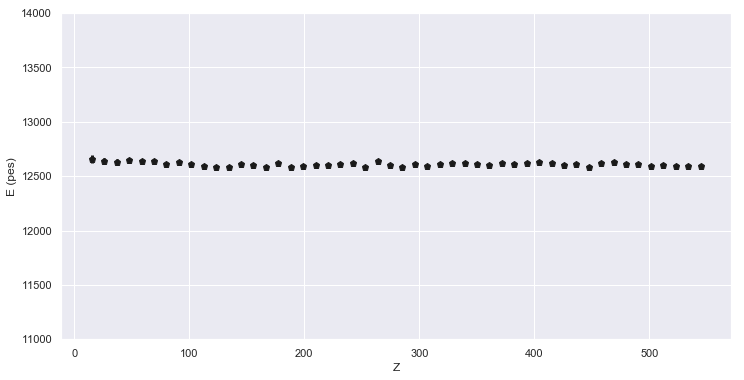

In [127]:
energy_X_profile(kse.Z, kse.E, xnbins = num_xy_bins, xrange=z_range, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))
plt.savefig(summary_outputs+'ZProfile.png')

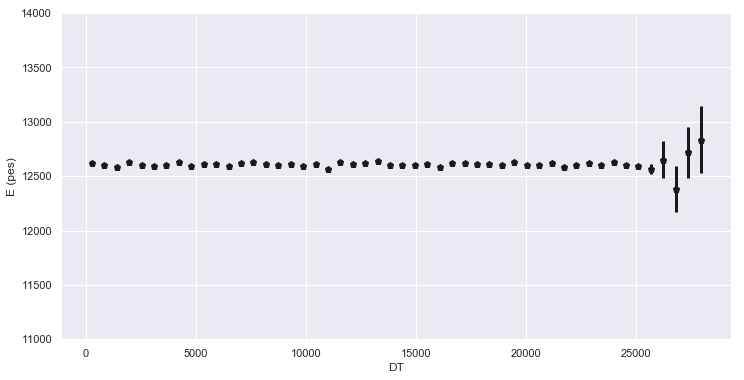

In [128]:
energy_X_profile(kse.DT, kse.E, xnbins = num_xy_bins, xrange=(kse.DT[0], kse.DT[-1]), xlabel = 'DT',
                 erange=e_range,   
                 figsize=(12,6))
plt.savefig(summary_outputs+'TProfile.png')

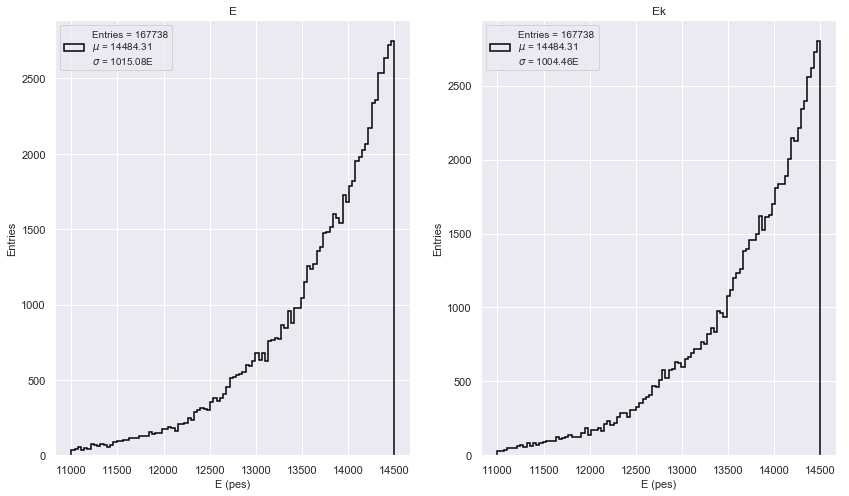

In [129]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(klt.E,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Ek'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 18020.341090071637 +-361.3604356728763 
 E sigma   = 2060.142480910257 +-81.81211107768011 
 chi2    = 1.457064562119929 
 sigma E/E (FWHM)     (%) =26.865944467646354
 sigma E/E (FWHM) Qbb (%) =3.4697892870278237 


/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


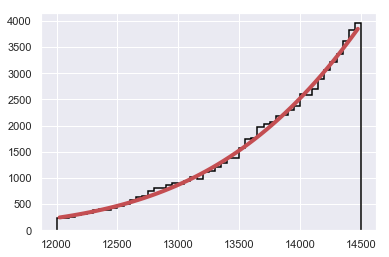

In [130]:
fc = fit_energy(Ek, nbins=50, range=(12000, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

 fit failed for seed  = GaussPar(mu=Measurement(value=13642.185355232768, uncertainty=79.36337445847823), std=Measurement(value=731.6941591007229, uncertainty=56.4514299484687), amp=Measurement(value=9.121713311636814, uncertainty=141.50275045218288))  due to RunTimeError
2019-01-27 20:16:39,210 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=13774.376077593328, uncertainty=37.95304019879278), std=Measurement(value=711.0499802237845, uncertainty=26.875163105850415), amp=Measurement(value=42.18055196505365, uncertainty=67.36604372644454))  due to RunTimeError
2019-01-27 20:16:39,247 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=13724.702616179053, uncertainty=13.526128915585389), std=Measurement(value=726.6439896474941, uncertainty=9.566074947146515), amp=Measurement(value=349.8412071335208, uncertainty=23.978593939756706))  due to RunTimeError
2019-01-27 20:16:39,352 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=13656.223888915027, uncertainty=35.72784823050914), std=Measurement(value=639.1191786657121, uncertainty=25.302970588312363), amp=Measurement(value=41.50972546635387, uncertainty=63.42514150882036))  due to RunTimeError
2019-01-27 20:16:39,386 | WARNING : No handles with labels found to put in legend.


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)


 fit failed for seed  = GaussPar(mu=Measurement(value=14528.999056233957, uncertainty=9.088585092647548), std=Measurement(value=748.4713316387304, uncertainty=6.427074001105026), amp=Measurement(value=740.5419864044571, uncertainty=16.11028541431565))  due to RunTimeError
2019-01-27 20:16:39,482 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=14535.612467913204, uncertainty=6.621637208732585), std=Measurement(value=746.0149360840197, uncertainty=4.682389024173633), amp=Measurement(value=1388.4464217338552, uncertainty=11.737008720815485))  due to RunTimeError
2019-01-27 20:16:39,520 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=13883.870878741893, uncertainty=17.665093724632232), std=Measurement(value=521.6439663732687, uncertainty=12.498276061457505), amp=Measurement(value=116.22344407454176, uncertainty=31.32853215979316))  due to RunTimeError
2019-01-27 20:16:39,555 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=13906.934175873184, uncertainty=8.07814823958157), std=Measurement(value=505.2557231465287, uncertainty=5.712843615480161), amp=Measurement(value=534.3041936143583, uncertainty=14.319975335107763))  due to RunTimeError
2019-01-27 20:16:39,590 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=13902.813146328815, uncertainty=4.847979128857495), std=Measurement(value=511.7316972830798, uncertainty=3.428192761514266), amp=Measurement(value=1483.1438716852858, uncertainty=8.593204906896988))  due to RunTimeError
2019-01-27 20:16:39,627 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=14520.798843888491, uncertainty=4.785100873077919), std=Measurement(value=653.2845713952944, uncertainty=3.383668045729943), amp=Measurement(value=1962.557801950483, uncertainty=8.481597995392095))  due to RunTimeError
2019-01-27 20:16:39,664 | WARNING : No handles with labels found to put in legend.


/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)
/Users/jmh

 fit failed for seed  = GaussPar(mu=Measurement(value=14525.091623930228, uncertainty=3.545925011186765), std=Measurement(value=655.8523575984741, uncertainty=2.507384268206216), amp=Measurement(value=3582.097675512967, uncertainty=6.285080302050661))  due to RunTimeError
2019-01-27 20:16:39,706 | WARNING : No handles with labels found to put in legend.


/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)
/Users/jmh

/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


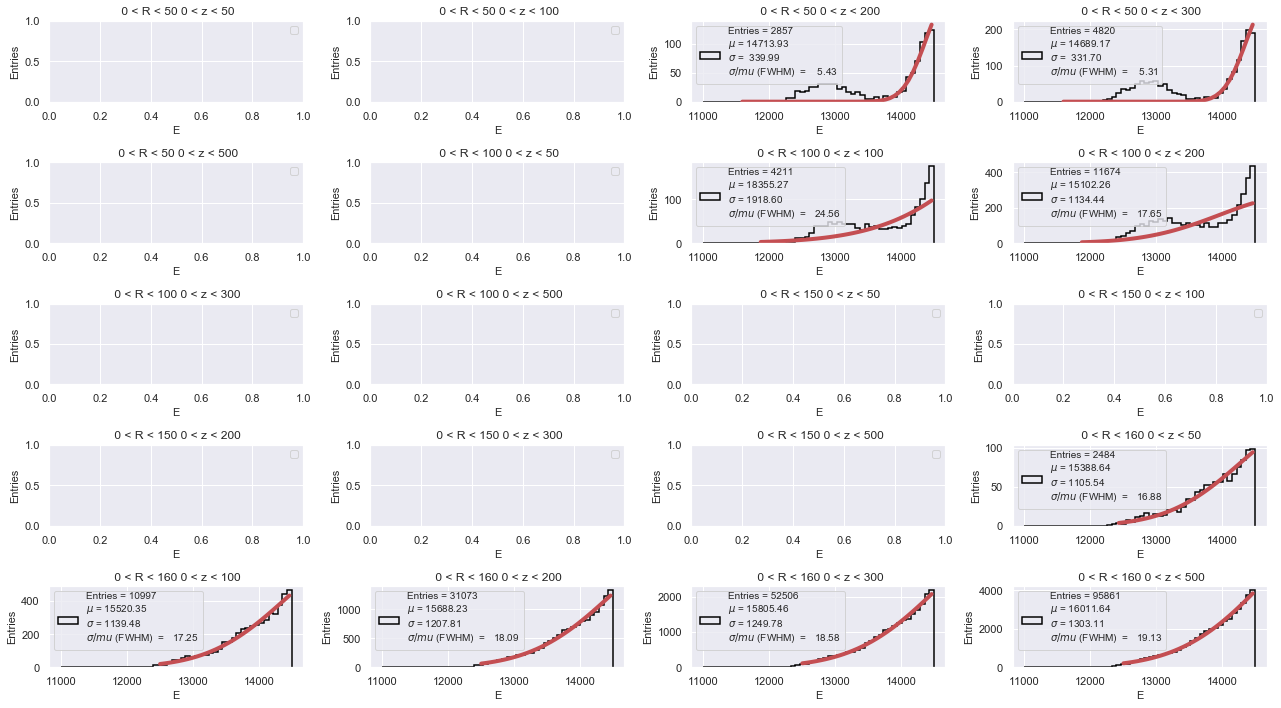

In [131]:
Ri = (50, 100,150,160)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, klt.R, klt.Z, Ek,
                    enbins = 50,
                    erange = (11e+3, 14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))
plt.savefig(summary_outputs+'ResoFit.png')

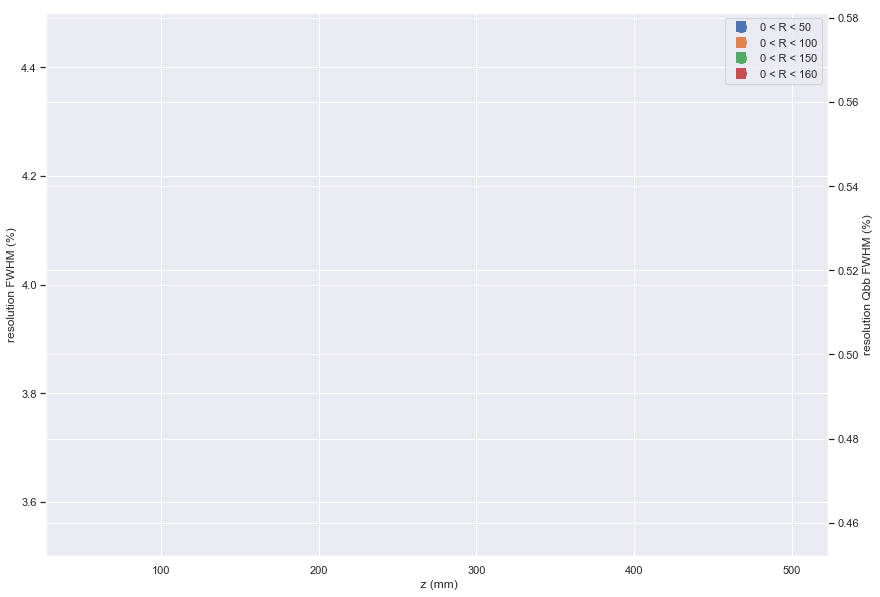

In [132]:
plot_resolution_r_z(Ri, Zi, FC, FCE)

 fit failed for seed  = GaussPar(mu=Measurement(value=13656.223888915027, uncertainty=35.72784823050914), std=Measurement(value=639.1191786657121, uncertainty=25.302970588312363), amp=Measurement(value=41.50972546635387, uncertainty=63.42514150882036))  due to RunTimeError
2019-01-27 20:16:44,895 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=14528.999056233957, uncertainty=9.088585092647548), std=Measurement(value=748.4713316387304, uncertainty=6.427074001105026), amp=Measurement(value=740.5419864044571, uncertainty=16.11028541431565))  due to RunTimeError
2019-01-27 20:16:44,972 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=14535.854922725895, uncertainty=7.623553491893659), std=Measurement(value=746.2909859075014, uncertainty=5.390947654812378), amp=Measurement(value=1056.2449196191794, uncertainty=13.513101818608389))  due to RunTimeError
2019-01-27 20:16:45,006 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=14535.612467913204, uncertainty=6.621637208732585), std=Measurement(value=746.0149360840197, uncertainty=4.682389024173633), amp=Measurement(value=1388.4464217338552, uncertainty=11.737008720815485))  due to RunTimeError
2019-01-27 20:16:45,041 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=13799.893822814309, uncertainty=23.395371116442583), std=Measurement(value=573.5445729804455, uncertainty=16.556805680125457), amp=Measurement(value=80.04657317219902, uncertainty=41.50175725537362))  due to RunTimeError
2019-01-27 20:16:45,087 | WARNING : No handles with labels found to put in legend.


/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jmh

 fit failed for seed  = GaussPar(mu=Measurement(value=14533.48152787714, uncertainty=6.160385151549978), std=Measurement(value=697.8930652291397, uncertainty=4.356219832722293), amp=Measurement(value=1369.3819841569402, uncertainty=10.919423803210027))  due to RunTimeError
2019-01-27 20:16:45,194 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=14540.072819289644, uncertainty=5.191611625696146), std=Measurement(value=697.4172303117093, uncertainty=3.671125502993938), amp=Measurement(value=1939.0323843681667, uncertainty=9.202146985523557))  due to RunTimeError
2019-01-27 20:16:45,233 | WARNING : No handles with labels found to put in legend.


 fit failed for seed  = GaussPar(mu=Measurement(value=14538.111904379683, uncertainty=4.548262049805114), std=Measurement(value=699.782302299626, uncertainty=3.216174870795863), amp=Measurement(value=2517.2708735161727, uncertainty=8.061754867294614))  due to RunTimeError
2019-01-27 20:16:45,284 | WARNING : No handles with labels found to put in legend.


/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Development/KryptonCalibration/KrCalib/krcal/core/fit_energy_functions.py:189: UserWarning:  fit did not succeed, cannot plot 
  warnings.warn(f' fit did not succeed, cannot plot ', UserWarning)
/Users/jmh

/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/Documents/NEXT_code/IC_current/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jmhaefner/minicond

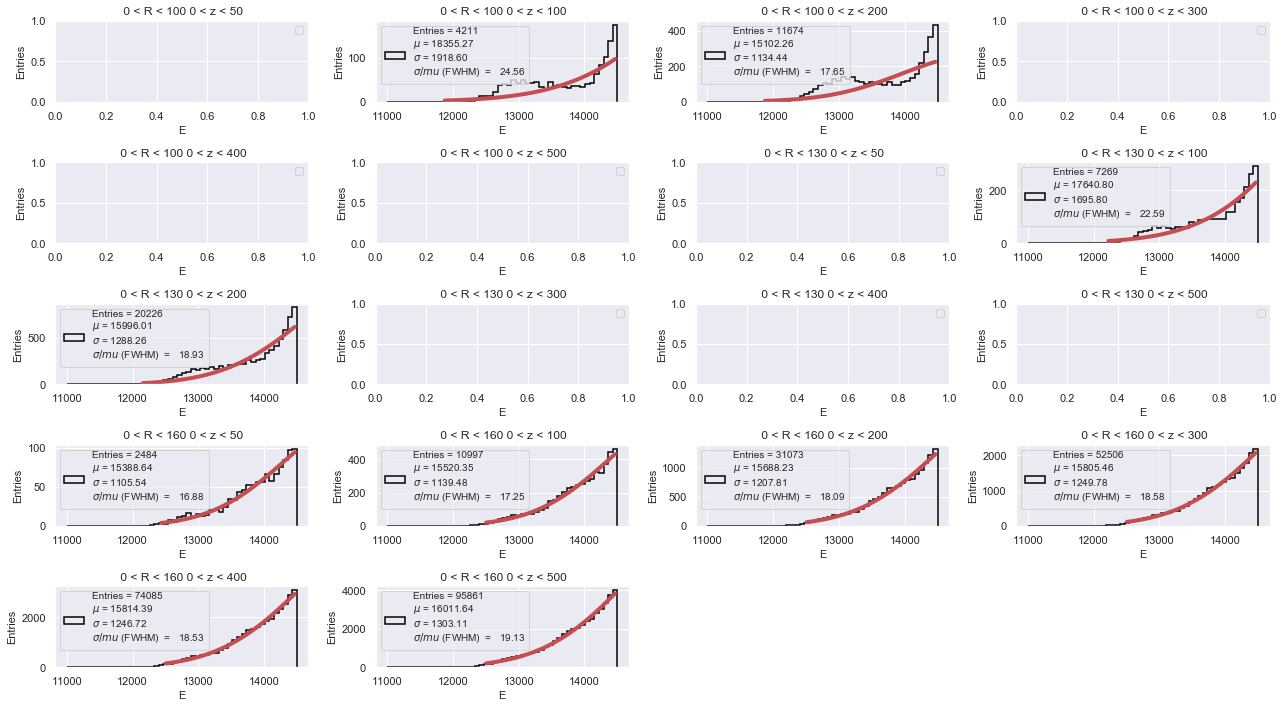

In [133]:
Ri = (100,130,160)
Zi = (50, 100,200,300,400,500)

FC, FCE = resolution_r_z(Ri, Zi, klt.R, klt.Z, Ek,
                    enbins = 50,
                    erange = (11e+3, 14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

/Users/jmhaefner/miniconda/envs/IC-3.6-2018-11-07/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


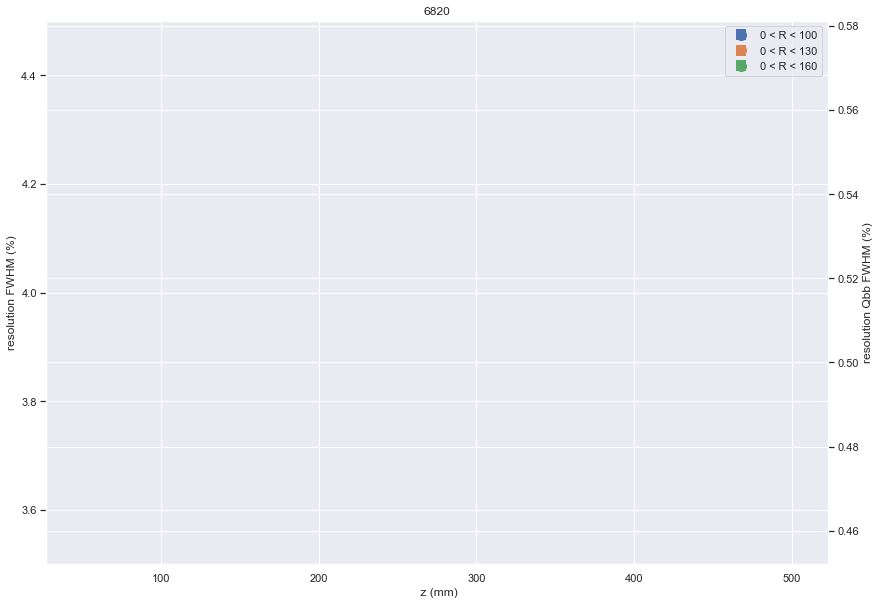

In [134]:
plot_resolution_r_z(Ri, Zi, FC, FCE, showPlots = False, plot_title=str(run_number))
plt.savefig(output_plots+'/res_vs_rz/res_vs_rz_'+str(run_number)+'.png')
plt.savefig(summary_outputs+'ResoVsZR.png')

In [135]:
dt_write = time_write - t_start
dt_plots = time.time() - time_write
print('Time to write =', round(dt_write/60.0,1), 'm')
print('Time to show plots =', round(dt_plots/60.0,1), 'm')

Time to write = 1.1 m
Time to show plots = 0.5 m
